# Hands On Instrument Data Selection and Binning

Please refer to [this notebook](https://github.com/arqus-gamma/arqus_school_2022/blob/main/hands_on/1_read_data/Read_data_with_astropy_hands_on.ipynb) for preliminary introduction

## Initial Setup

As usual, we start by installing some standards packages. We try to be minimal and install only those stricly required.
Check package versions. All examples should work with Astropy > 2.0 and Numpy > 1.11

In [2]:
%matplotlib inline  
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import astropy
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
# from astropy.time import Time
from astropy.table import Table
from astropy.io import fits


print('numpy:', np.__version__)
print('astropy:', astropy.__version__)

numpy: 1.22.3
astropy: 5.0.4


However, in most cases, remember that for analyzing specific instruments' data, often additional packages are to be installed, that are somewhat specific of the instrument. In many cases, they are tailored functions

In [37]:
import gammapy
from gammapy.data import Observation, Observations, DataStore
from gammapy.makers import SafeMaskMaker, MapDatasetMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, WobbleRegionsFinder

# dataset modules
from gammapy.datasets import (
    MapDataset, 
    MapDatasetOnOff, 
    MapDatasetEventSampler,
    SpectrumDatasetOnOff,
    SpectrumDataset, 
    Datasets,
    FluxPointsDataset
)

In [81]:
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.wcs import WCS

## 1. Data Sample

In this part we start selecting the data of interest for the further analysis.

Let's first check what's in the data folder. The mark `!` specifies a terminal line command

In [193]:
!ls ../../data/

README.md          crab_nebula        ic310              pks2155
arqus_filelist.txt download_data.sh   ngc1275


We see that we have 4 targets, as well the complete list of files. Let's open one target, the 'crab nebula'. This dataset comes from a joint publication about that source with a small subsample of data from different experiments. Normally data are private this is the reason for the 'small dataset' for that source.


In [194]:
!ls ../../data/crab_nebula/
#!ls ../../data/pks2155/

fact    fermi   hess    magic   other   veritas
hess


Great! More than 5 instruments data for our targets. Let's start with MAGIC data:

In [242]:
#!ls ../../data/crab_nebula/magic
#!ls ../../data/pks2155/hess/
#!ls ../../data/ic310/magic
!ls ../../data/ngc1275/magic

20170101_05059487_DL3_NGC1275-W0.40+157.fits
20170101_05059488_DL3_NGC1275-W0.40+337.fits
20170101_05059489_DL3_NGC1275-W0.40+058.fits
20170101_05059490_DL3_NGC1275-W0.40+238.fits
20170101_05059497_DL3_NGC1275-W0.40+238.fits
20170101_05059498_DL3_NGC1275-W0.40+157.fits
20170101_05059499_DL3_NGC1275-W0.40+337.fits
20170101_05059500_DL3_NGC1275-W0.40+337.fits
hdu-index.fits.gz
obs-index.fits.gz


So we have two files (run): 05029747 and 05029748. Let's open one of them. 

In [208]:
#fits_file = fits.open('../../data/crab_nebula/magic/run_05029747_DL3.fits')
fits_file = fits.open('../../data/ngc1275/magic/20170101_05059487_DL3_NGC1275-W0.40+157.fits')
#fits_file = fits.open('../../data/pks2155/hess/hess_dl3_dr1_obs_id_033787.fits.gz')
#fits_file = fits.open('../../data/ic310/magic/20121113_05020910_DL3_NGC1275-W0.40+238.fits')

In [246]:
#m astropy.table import Table, hstack

#t1 = Table.read('../../data/ngc1275/magic/20170101_05059487_DL3_NGC1275-W0.40+157.fits', format='fits')
#t2 = Table.read('../../data/ngc1275/magic/20170101_05059498_DL3_NGC1275-W0.40+157.fits', format='fits')
#new = hstack([t1, t2])
#new.write('combined.fits')

To see what's inside we have a look at the Data Units. Let's check the header data unit (HDU) by calling `.info()`:

In [209]:
fits_file.info()

Filename: ../../data/ngc1275/magic/20170101_05059487_DL3_NGC1275-W0.40+157.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  EVENTS        1 BinTableHDU     62   12614R x 8C   [1K, 1D, 1E, 1E, 1E, 1E, 1E, 1E]   
  2  GTI           1 BinTableHDU     24   1R x 2C   [1D, 1D]   
  3  RAD_MAX       1 BinTableHDU     33   1R x 5C   [28E, 28E, 1E, 1E, 28E]   
  4  EFFECTIVE AREA    1 BinTableHDU     35   1R x 5C   [40E, 40E, 1E, 1E, 40E]   
  5  ENERGY DISPERSION    1 BinTableHDU     36   1R x 7C   [40E, 40E, 28E, 28E, 1E, 1E, 1120E]   


We see that we have:
* PRIMARY which contains file-related information
* EVENTS contains the actual event list of our interest
* GTI contains the 
* EFFECTIVE AREA is an important experiment information  
* ENERGY DISPERSION is a second important experimental information

We import the PRIMARY and check what is inside. The PRIMARY contains only a short header and no data

In [210]:
primary = fits_file['PRIMARY'] 
primary.header
#primary.data

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

Let's look at the EVENT HDU. Here are the events information. First with the header

In [211]:
events = fits_file['EVENTS'] 
events.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   40 / width of table in bytes                        
NAXIS2  =                12614 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    8 / number of fields in each row                   
TTYPE1  = 'EVENT_ID'           / label for field   1                            
TFORM1  = '1K      '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'TIME    '           / label for field   2                            
TFORM2  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT2  = 's       '        

Here are a bunch of interesting 'observational' parameter. Let's save some useful parameters

Of all the entries, some are worth discussing

```
OBS_ID  =              5059487 / unique observation identifier                  
TSTART  =         4.361391E+08 / [s] observation start time                     
TSTOP   =         4.361403E+08 / [s] observation end time                       
ONTIME  =                1193. / [s] total good time (sum of GTIs)              
LIVETIME=             1178.607 / [s] total effective time                       
OBS_MODE= 'POINTING'           / observation mode                               
RA_OBJ  =                49.95 / [deg] source RA                                
DEC_OBJ =             41.51167 / [deg] source DEC                               
OBS_MODE= 'Wobble  '           / observation mode                               
RA_PNT  =             49.45417 / [deg] observation pointing RA                  
DEC_PNT =             41.66806 / [deg] observation pointing DEC                 
ALT_PNT =             76.89065 / [deg] average altitude pointing                
AZ_PNT  =            -6.315182 / [deg] average azimuth pointing
```

In [212]:
# Useful parameters from the EVENT header.
ra_obj  = events.header['RA_OBJ']
dec_obj = events.header['DEC_OBJ']
ra_pnt  = events.header['RA_PNT']
dec_pnt = events.header['DEC_PNT']  

Being sky positions, it is more convenient to convert them in

In [213]:
pointing_pos =  SkyCoord( events.header.get('RA_PNT') *u.deg,   events.header.get('DEC_PNT') *u.deg )
source_pos   =  SkyCoord.from_name(events.header.get('OBJECT'))

Let's check the different of the two:

In [214]:
offset = source_pos.separation(pointing_pos)
offset.to( u.deg).value

0.40291469991647577

There is a difference of 0.4 deg between the true source position and the pointing position. Why? Because IACTs points the targets slightly off according to the Wobble solution, for a more accurate background estimation...see later!

Besides the header, let's see what are the DATA of the EVENT HDU:


In [215]:
events.data
events.columns.names

# Better uncomment the line below and use the astropy Table class
Table(events.data)

EVENT_ID,TIME,RA,DEC,ENERGY,GAMMANESS,DETX,DETY
int64,float64,float32,float32,float32,float32,float32,float32
117,436139121.599158,49.01414,41.539272,0.10293761,0.9410159,0.3199254,-0.13709812
138,436139121.66326886,48.04316,42.417595,0.06289925,0.41138095,1.0475081,0.7366911
210,436139121.89286935,49.00081,41.941536,0.040962473,0.24814683,0.33467507,0.2649405
233,436139121.9688521,48.99533,41.803627,0.034511823,0.32546824,0.33711714,0.12696764
337,436139122.25264156,49.906765,42.391163,0.05785944,0.7387659,-0.32914373,0.7258594
355,436139122.2984954,50.021763,41.50761,0.29707232,0.8527024,-0.43491018,-0.15557902
364,436139122.31179434,49.556606,41.83252,0.115851775,0.78795886,-0.08073081,0.16200143
365,436139122.3160477,48.488037,42.43964,0.13334548,0.88278574,0.7189447,0.75967366
395,436139122.41501117,48.45039,40.33354,0.39297318,0.9098333,0.7355171,-1.3470265


We can check the whole number of events with the command

In [216]:
len(events.data)

12614

Let's see some events

In [217]:
en  = events.data['ENERGY']
t   = events.data['TIME']
ra  = events.data['RA']
dec = events.data['DEC']
g   = events.data['GAMMANESS']
#dx  = events.data['DETX']
#dy  = events.data['DETY']

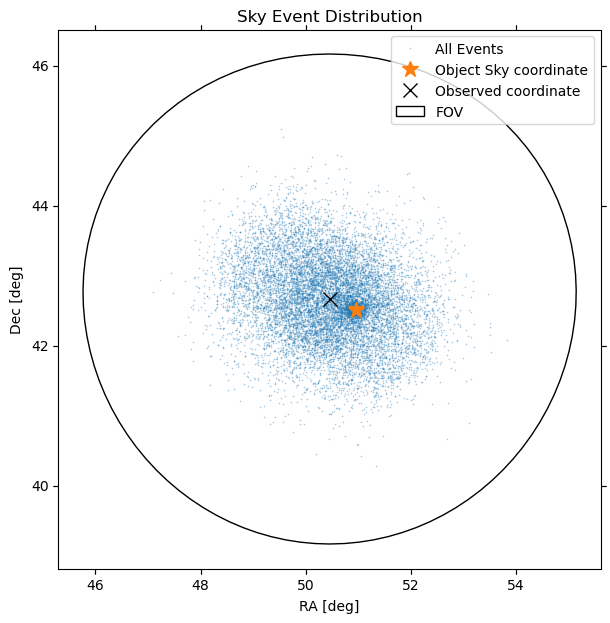

In [218]:
# Direction of the events
fig, ax =  plt.subplots(figsize=(7,7))
ax = plt.subplot(projection=wcs)


ax.plot(ra,dec,marker='s', markersize='0.2',linewidth='0',alpha=0.5, label="All Events")
ax.plot(ra_obj,dec_obj, marker="*", markersize="12",linewidth='0', label="Object Sky coordinate")
ax.plot(ra_pnt,dec_pnt, marker="x", color = 'black', markersize="10", linewidth='0', label="Observed coordinate")


fov = SphericalCircle( (pointing_pos.ra, pointing_pos.dec),
                    3.5 * u.deg,   edgecolor='black', facecolor='none', label="FOV")
ax.add_patch(fov)
plt.ylabel('Dec [deg]')
plt.xlabel('RA [deg]')
plt.title('Sky Event Distribution')
ax.legend(loc="best")

Let's look at how the energy of the data is distributed

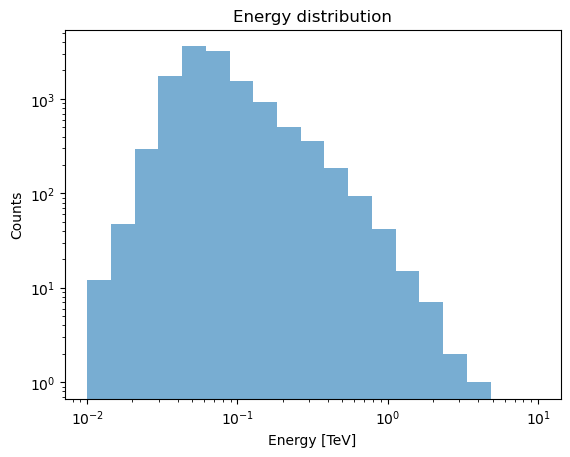

In [219]:
binning = np.logspace(-2,1,20)
plt.hist(en,bins=binning,alpha=0.6,log=True)
plt.xlabel('Energy [TeV]')
plt.ylabel('Counts')
plt.title('Energy distribution')
plt.xscale('log')

What we see is that we have a peak at about 0.1 TeV, a sudden increase below and a regular decrease above that value? Does this make sense? Does the target source have a peak at 0.1 TeV? 

To understand this we need to look at the effective area of the telescope.

The effective area is the geometrical area of an instrument multiplied with the instrument efficiency. For example, take a tennis racket. The geometrical area is the area of the net, but not the whole are of the net is efficient. In the outer rim the ball would be launched uncorrectly. For a telescope like MAGIC:
* the geometrical area is the area illuminated in the ground by the Cherenkov ligth
* the efficiency is the ratio between all events and those that are actually recorded in the instrument
The effective area is normally obtained with Monte Carlo simulations and not from the data.

In [220]:
effarea = fits_file['EFFECTIVE AREA'] 
effarea.header
Table(effarea.data)


ENERG_LO [40],ENERG_HI [40],THETA_LO,THETA_HI,"EFFAREA [1,40]"
float32,float32,float32,float32,float32
0.0050000004 .. 39.716415,0.006294627 .. 50.000004,0.39,0.41,0.0 .. 0.0


This look in a strange format, but the reason is because the effective area may depend on the distance from the center of the camera. Here only one effective area is simulated. Let's see how it looks like

Text(0, 0.5, 'Area [m^2]')

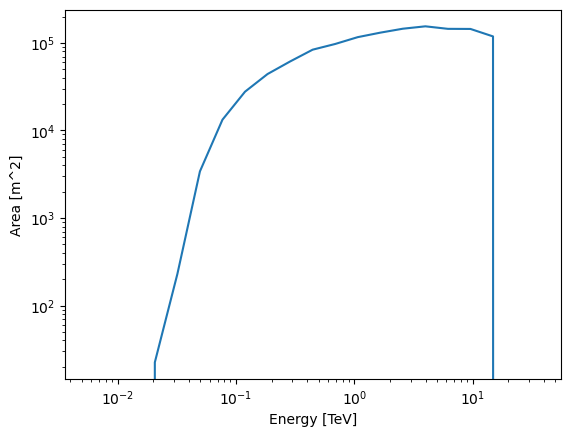

In [27]:
effarea.data['ENERG_LO'][0]
effarea.data['EFFAREA'][0][0]
plt.loglog(effarea.data['ENERG_LO'][0],effarea.data['EFFAREA'][0][0])
plt.xlabel('Energy [TeV]')
plt.ylabel('Area [m^2]')


One sees here that the instrument effective area is almost constant from 1 to 10 TeV. Above 10-20 TeV the effective area goes suddenly to zero, while below 0.1 TeV it decreases more slowly. Whis is that?

In [221]:
enres = fits_file['ENERGY DISPERSION'] 
enres.header
Table(enres.data)
enres.columns.names

['ENERG_LO',
 'ENERG_HI',
 'MIGRA_LO',
 'MIGRA_HI',
 'THETA_LO',
 'THETA_HI',
 'MATRIX']

Again, this is a matrix of information, let' see:

In [239]:
#enres.data['ENERG_LO'][0]
#enres.data['MIGRA_LOW'][0]
#enres.data['MIGRA_HI'][0]

Finally, let's discuss the GAMMANESS parameter (for some files only).

Text(0, 0.5, 'Counts')

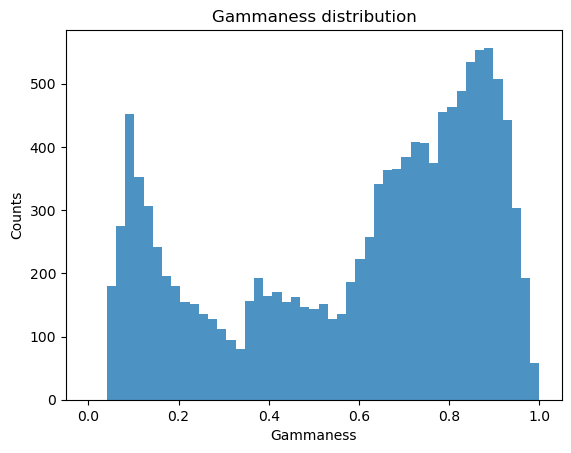

In [223]:
binning = np.linspace(0,1,50)
plt.hist(g,bins=binning,alpha=0.8)
plt.title('Gammaness distribution')
plt.xlabel('Gammaness')
plt.ylabel('Counts')

These are all events from all directions in the sky. We will learn that MOST of them are background event, while only some of them are signal events. How do we extract the good ones from the full datasample?

## Definition of the signal-search region
Let's start by defining a region in which we expect the signal to be from a region where we expect to find only background. This a standard procedure called
* signal region definition
* background control region definition

The signal come from a specific direction in the sky. If the instrument had an infinite angular resolution (also one should assume no shower fluctuations), in principle all events should come from A SINGLE POINT. However, they come from a region. This region is often defined as a circle around the true target position. Circles are better identified with astropy tools.

In [224]:
source_angle = pointing_pos.position_angle(source_pos).to(u.degree)
radius = offset/np.sqrt(2)
radius /=2

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='red', facecolor='none', label="ON REGION")


In [225]:
wcs = WCS(events.header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


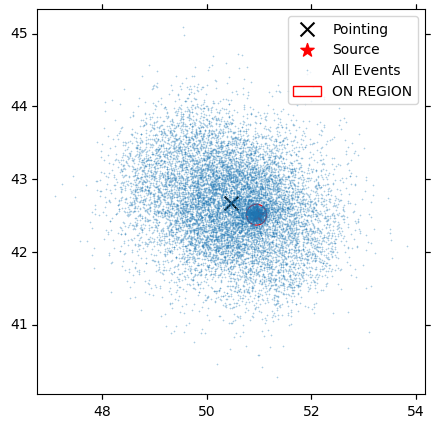

In [226]:
fig, ax =  plt.subplots(figsize=(5,5))
ax = plt.subplot(projection=wcs)


ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 
ax.plot(ra,dec,marker='s', markersize='0.2',linewidth='0',alpha=0.5, label="All Events")

#ax.add_patch(fov)
ax.add_patch(on)

ax.legend(loc= "best");

In [227]:
ra = events.data['RA'] 
dec = events.data['DEC']

cond_on = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_on.append( source_pos.separation(position_event) < radius )

In [235]:
# Selection
#evt = events.data[cond_on]
evt = events.data[cond_on * (events.data['ENERGY'] > 0.1) * (events.data['ENERGY'] < 10)]
print(f"Events before cut: " + str(len(events.data)))
print(f"Events after sel: " + str(len(evt)))



Events before cut: 12614
Events after sel: 536


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  4., 11., 10., 11., 14., 19., 18., 23., 23.,
        27., 21., 35., 38., 49., 55., 53., 52., 55., 18.]),
 array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
        0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
        0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
        0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
        0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
        0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
        0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
        0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ]),
 <BarContainer object of 49 artists>)

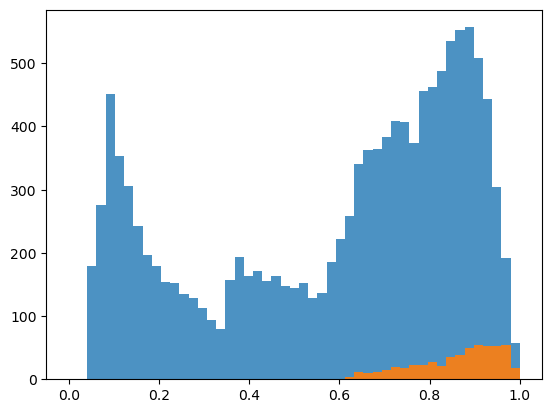

In [236]:
gsel = evt['GAMMANESS']
binning = np.linspace(0,1,50)
plt.hist(g,bins=binning,alpha=0.8)
plt.hist(gsel,bins=binning,alpha=0.9)

In [237]:
evt_sig = events.data[cond_on * (events.data['GAMMANESS'] > 0.7)]
evt_bkg = events.data[cond_on * (events.data['GAMMANESS'] < 0.7)]
print(f"Events candidates for sig: " + str(len(evt_sig)))
print(f"Events candidates for bkg: " + str(len(evt_bkg)))

Events candidates for sig: 754
Events candidates for bkg: 225


In [238]:
# Here I would put a theta2-plot

In [233]:
theta2_sig = source_pos.separation(source_pos)

In [234]:
ra = evt_sig['RA'] 
dec = evt_sig['DEC']

th2_on = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')
    th2_on.append( source_pos.separation(position_event)*source_pos.separation(position_event))

ra = evt_bkg['RA'] 
dec = evt_bkg['DEC']

th2_off = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')
    th2_off.append( source_pos.separation(position_event)*source_pos.separation(position_event))
    
#th2_on

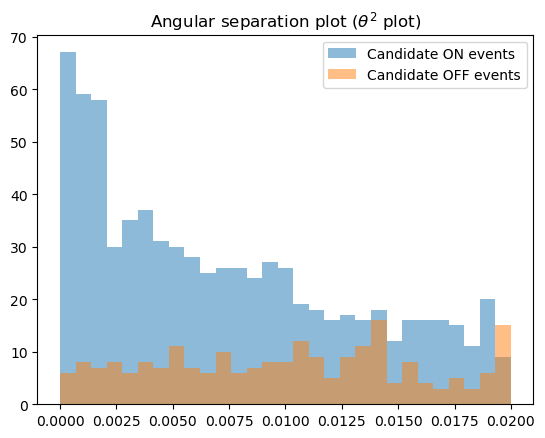

In [192]:
binning = np.linspace(0,0.02,30)
plt.hist(th2_on,bins=binning,alpha=0.5,label='Candidate ON events')
plt.hist(th2_off,bins=binning,alpha=0.5,label='Candidate OFF events')
plt.title(r'Angular separation plot ($\theta^2$ plot)')
plt.legend(loc='best')

In [ ]:
# Try with selected higher energy events?

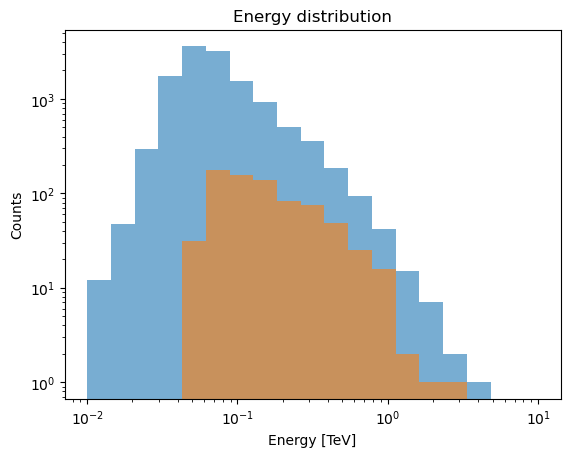

In [240]:
binning = np.logspace(-2,1,20)
plt.hist(en,bins=binning,alpha=0.6,log=True)
plt.hist(evt_sig['ENERGY'],bins=binning,alpha=0.6,log=True)
plt.xlabel('Energy [TeV]')
plt.ylabel('Counts')
plt.title('Energy distribution')
plt.xscale('log')

In [241]:
# From counts --> nimber of excesss --> flux

## Data selection

1/ Quality of data

2/ Data selection for the purpose of the analysis


In [ ]:
# Selection
#cut1 = events.data['ENERGY'] > 0.01, events.data['ENERGY'] < 0.1
#cut2 = events.data['ENERGY'] > 10, events.data['ENERGY'] < 100
evt1 = events.data[(events.data['ENERGY'] > 0.01) * (events.data['ENERGY'] < 0.1) * (events.data['GAMMANESS'] > 0.95)]
evt2 = events.data[(events.data['ENERGY'] > 0.1) * (events.data['ENERGY'] < 10) * (events.data['GAMMANESS'] > 0.95)]
evt3 = events.data[(events.data['GAMMANESS'] > 0.95)]
print(len(events.data))
print(len(evt1))
print(len(evt2))

In [ ]:
en_s1  = evt1['ENERGY']
t_s1   = evt1['TIME']
ra_s1  = evt1['RA']
dec_s1 = evt1['DEC']
g_s1   = evt1['GAMMANESS']

In [ ]:
en_s2  = evt2['ENERGY']
t_s2   = evt2['TIME']
ra_s2  = evt2['RA']
dec_s2 = evt2['DEC']
g_s2   = evt2['GAMMANESS']

In [ ]:
en_s3  = evt3['ENERGY']
t_s3   = evt3['TIME']
ra_s3  = evt3['RA']
dec_s3 = evt3['DEC']
g_s3   = evt3['GAMMANESS']

In [ ]:
# Direction of the events
plt.plot(dec,ra,marker='s', markersize='0.2',linewidth='0',alpha=0.5, label="all")
plt.plot(dec_s1,ra_s1,marker='o', markersize='2',linewidth='0',alpha=0.5, label="Low Energy")
plt.plot(dec_s2,ra_s2,marker='o', markersize='2',linewidth='0',alpha=0.5, label="High Energy")
plt.plot(dec_s3,ra_s3,marker='o', markersize='2',linewidth='0',alpha=0.5, label="Gammaness > 0.95")
plt.plot(dec_obj,ra_obj, marker="*", markersize="12",linewidth='0', label="Object Sky coordinate")
plt.plot(dec_pnt,ra_pnt, marker="x", color = 'black', markersize="10", linewidth='0', label="Observed coordinate")
plt.xlabel('Dec [deg]')
plt.ylabel('RA [deg]')
plt.title('Sky Event Distribution')
plt.legend(loc="best")

In [ ]:
# Selection
cuts1 = events.data['GAMMANESS'] > 0.95
evt = events.data[cuts1]
print(len(events.data))
print(len(evt))

In [ ]:
ensel = evt['ENERGY']
tsel   = evt['TIME']
rasel     = evt['RA']
decsel    = evt['DEC']
gsel = evt['GAMMANESS']
dxsel   = evt['DETX']
dysel   = evt['DETY']

In [ ]:
# Direction of the events
plt.plot(dec,ra,marker='s', markersize='0.2',linewidth='0',alpha=0.6, label="all")
plt.plot(decsel,rasel,marker='s', markersize='0.4',linewidth='0',label="selected")
plt.xlabel('Dec [deg]')
plt.ylabel('RA [deg]')
plt.legend(loc="best")

In [ ]:
# Direction of the events
plt.plot(dx,dy,marker='s', markersize='0.2',linewidth='0')


In [ ]:
binning = np.linspace(0,1,50)
plt.hist(g,bins=binning,alpha=0.8)
plt.hist(gsel,bins=binning,alpha=0.9)


Everything looks ok. For the sake of the following part we need the EVENTS tables for the moment

In [ ]:
energy = events.data['ENERGY']
time = events.data['TIME']
condizione = energy > 1.05
condtemp = time >  334778850.0339344
event_sel = events.data[condizione*condtemp]
event_sel
gammaness = event_sel['GAMMANESS']
len(gammaness)
#Table(event_sel)
#plt.hist(energy, bins=1000)

## Effective Area

In [ ]:
effarea = fits_file['EFFECTIVE AREA'] 
effarea.header
Table(effarea.data)
enlo = effarea.data['ENERG_LO']
aeff = effarea.data['EFFAREA']
x = enlo[0]
y = aeff[0][0]
x*u.TeV

In [ ]:
plt.loglog(x,y)
plt.xlabel('Energy [TeV]')
plt.ylabel('Area [m^2]')

In [ ]:
binning = np.logspace(-2,1,20)
plt.hist(en,bins=binning,alpha=0.6,log=True)
plt.hist(ensel,bins=binning,alpha=0.8,log=True)
plt.xscale('log')